In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

from datetime import datetime
from datetime import timedelta
from IPython.display import Image
import pickle

%matplotlib inline

In [ ]:
df_train_stops = pd.read_csv('http://web.mta.info/developers/data/nyct/subway/Stations.csv')

In [ ]:
len(df_train_stops['Stop Name'].unique())

### Making a df from turnstile data

In [ ]:
dates = ['170624', '170617', '170610', '170603', '170527', '170520', '170513', '170506', '160625', '160618', '160611', '160604', '160528', '160521', '160514', '160507']

chronological_dates = list(reversed(dates))

In [ ]:
turnstile_df_raw = pd.DataFrame()

for date in chronological_dates:
    base = 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_'
    url = base + date + '.txt'
    print(url)
    df = pd.read_csv(url)
    turnstile_df_raw = pd.concat([turnstile_df_raw, df], ignore_index=True)

In [ ]:
# to save a pickle file _ Summer
path = '/Volumes/ext200/Dropbox/metis/MTABenson_metis/pklfiles/'
with open(path + 'turnstile_df_raw.pkl', 'wb') as picklefile:
    pickle.dump(turnstile_df_raw, picklefile)
with open(path + 'another100.pkl', 'wb') as picklefile:
    pickle.dump(another100, picklefile)
with open(path + 'unclean_100.pkl', 'wb') as picklefile:
    pickle.dump(unclean_100, picklefile)        

In [ ]:
path = '/Volumes/ext200/Dropbox/metis/MTABenson_metis/pklfiles/'

with open(path + 'tuestop.pkl', 'wb') as picklefile:
    pickle.dump(tuestop, picklefile)        

In [2]:
# to open a pickle file_Summer
path = '/Volumes/ext200/Dropbox/metis/MTABenson_metis/pklfiles/'
with open(path + "turnstile_df_raw.pkl", 'rb') as picklefile: 
    turnstile_df_raw = pickle.load(picklefile)
with open(path + "another100.pkl", 'rb') as picklefile: 
    another100 = pickle.load(picklefile)
with open(path + "unclean_100.pkl", 'rb') as picklefile: 
    unclean_100 = pickle.load(picklefile)

### Get and Compute the total number of people in and out of each station, each day.

In [12]:
def ppl_per_int_turnst(datafrm):
    """function to subtract the ENTRIES and EXITS collected at the starting hour for the day (i.e., 00:00:00 hrs) from the entries 
    and exits collected during the next collection time (i.e. 'TIME =04:00:00 hrs) for each turnstile in MTA, and the length of
    the corresponding time interval (HR_DELTA). 
    ----------
    datafrm= dataframe from MTA turnstile data
    output(2dataframes) = 1. includes the outliers   2. cleaned data """
#----------------------------------------------------------  
    datafrm.rename(columns = {datafrm.columns[-1]:'EXITS'}, inplace=True) #deal with col name that sucks
    datafrm = datafrm.loc[:,['DATE','STATION','LINENAME','SCP','TIME','ENTRIES','EXITS']] #only what we want
    
    #convert/extract date/time info
    datafrm['TIME'] = pd.to_datetime(datafrm.loc[:,('TIME')]).dt.hour #, format='%H:%M:%S') #make into datetime object
    datafrm['DATE_OBJ'] =pd.to_datetime(datafrm.loc[:,('DATE')])#make into datetime object
    datafrm['WEEKDAY'] =datafrm.loc[:,('DATE_OBJ')].apply(lambda i: i.weekday()) #get day of week  
    datafrm = datafrm[(datafrm.DATE != '05/30/2016') | (datafrm.DATE != '05/29/2017')] # remove memorial days
    
    #subtract entries/exit number of people by rows (time increments) and get absolute value
    datafrm['ENTRY_DIFF'] = datafrm.groupby(['DATE','LINENAME','STATION','SCP'])['ENTRIES'].transform(lambda x: x.diff())
    datafrm['ENTRY_DIFF'] = datafrm['ENTRY_DIFF'].abs()
    datafrm['EXIT_DIFF'] = datafrm.groupby(['DATE','LINENAME','STATION','SCP'])['EXITS'].transform(lambda x: x.diff())
    datafrm['EXIT_DIFF'] =datafrm['EXIT_DIFF'].abs() 
    
    # get number of hours in each increment collected
    datafrm['HR_DELTA'] = datafrm.groupby(['DATE','LINENAME','STATION','SCP'])['TIME'].transform(pd.Series.diff)   
    # remove duplicates or intervals that were longer than one day
    datafrm = datafrm[(datafrm.HR_DELTA !=0)& (datafrm.HR_DELTA <=23) ] 
    
    #compute the max number of ppl for each interval
    datafrm['MAX'] = datafrm.loc[:,('HR_DELTA')].apply(lambda q: q * 720) 
    
    # divide entries by number of hours for hourly rate
    datafrm['EN_HRLY_RATE'] = datafrm['ENTRY_DIFF']/datafrm['HR_DELTA']
    datafrm['EX_HRLY_RATE'] = datafrm['EXIT_DIFF']/datafrm['HR_DELTA']
    
    # calc total flow of people in and out for each interval 
    datafrm['SUM_PPL']= datafrm['ENTRY_DIFF'] + datafrm['EXIT_DIFF']
    #___________________________________________________________________________________
    # create a second cleaned df by throwing out interval collection times > MAX 
    clean_datafrm = datafrm.query('(ENTRY_DIFF <= MAX)')
    clean_datafrm = clean_datafrm.query('(EXIT_DIFF <= MAX)')
    
    # calc total flow of people in and out for each interval 
    clean_datafrm['SUM_PPL']= clean_datafrm['ENTRY_DIFF'] + clean_datafrm['EXIT_DIFF']
    
    return datafrm, clean_datafrm

In [ ]:
# call cleaning function 
unclean_100, another100 = ppl_per_int_turnst(turnstile_df_raw)

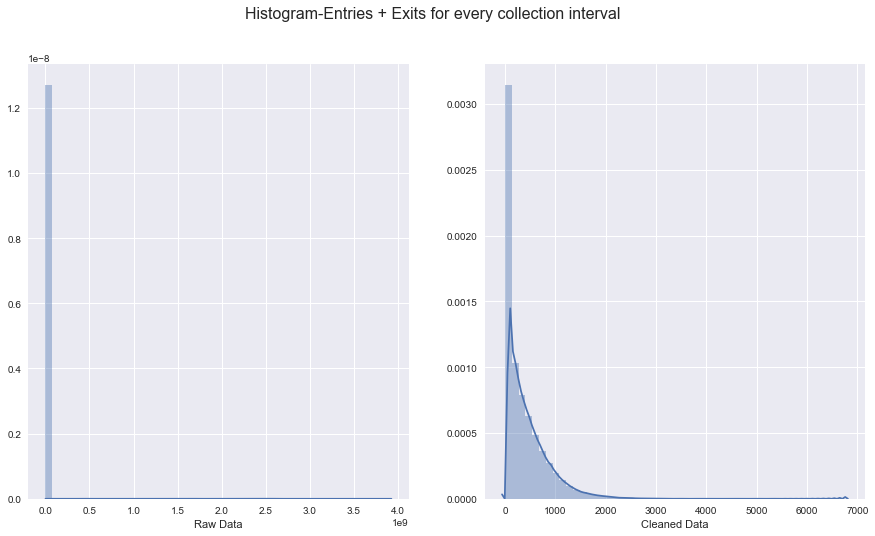

In [13]:
fig = plt.figure(figsize=(15, 8));  # Size of the total canvas
fig.suptitle("Histogram-Entries + Exits for every collection interval",fontsize=16);
             
xU = unclean_100.SUM_PPL# < 10000 #ENTRY_DIFF
plt.subplot(1, 2, 1);
sns.distplot(xU) #, bins=45,range=[0,1500]);

#plt.hist(xU, bins=45,range=[0,1500]);
plt.xlabel('Raw Data')

yU = another100.SUM_PPL #EXIT_DIFF
plt.subplot(1, 2, 2);  
sns.distplot(yU) #, bins=45,range=[0,1500]);
plt.xlabel('Cleaned Data');
#plt.hist(yU, bins=45);#,range=[0,1500]);


In [14]:
# sum over the time intervals for each turnstile 
per_turn= another100.groupby(['DATE_OBJ','LINENAME','STATION','SCP']).sum()

In [15]:
# sum over turnstile totals for each station, and eaah day 
#SUM_PPL will be the value to look at. 
per_stn=per_turn.groupby(['DATE_OBJ','LINENAME','STATION']).sum()
per_stns = per_stn.reset_index()
#pull weekday info again (we summed it, so it's wrong)
per_stns['WEEKDAY'] = per_stns.loc[:,('DATE_OBJ')].apply(lambda s: s.weekday()) #0=Monday, etc... 

In [16]:
# now, get the mean of each station for each day of the week (M=F) 
per_weekD = per_stns.groupby(['WEEKDAY','LINENAME','STATION']).mean()
per_weekD = per_weekD.reset_index()

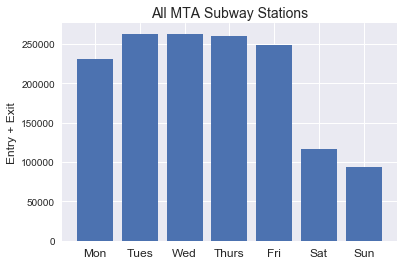

In [20]:
#plot weekday ridership for all stations
plt.bar(per_weekD.WEEKDAY, per_weekD.SUM_PPL);
plt.title('All MTA Subway Stations',fontsize=14);
plt.ylabel('Entry + Exit',fontsize=12);
plt.xticks(np.arange(7), ('Mon', 'Tues', 'Wed', 'Thurs', 'Fri','Sat','Sun'),fontsize=12 );

In [21]:
tues = per_weekD.query('(WEEKDAY== 1)')

In [22]:
tues = tues.sort_values(['SUM_PPL'],ascending=False)
tuestop = tues[0:50]
categories = tuestop.STATION.unique()
categories

array(['GRD CNTRL-42 ST', '34 ST-HERALD SQ', '34 ST-PENN STA',
       '42 ST-PORT AUTH', '14 ST-UNION SQ', '47-50 STS ROCK',
       'TIMES SQ-42 ST', 'PATH NEW WTC', 'FULTON ST', 'FLUSHING-MAIN',
       '59 ST COLUMBUS', '86 ST', '59 ST', 'LEXINGTON AV/53',
       '42 ST-BRYANT PK', 'CANAL ST', 'JKSN HT-ROOSVLT', '72 ST', '96 ST',
       'W 4 ST-WASH SQ', 'JAMAICA CENTER', 'PATH WTC', '77 ST',
       'BOWLING GREEN', 'JAY ST-METROTEC', 'BOROUGH HALL', 'KEW GARDENS',
       '5 AV/53 ST', '33 ST', 'WALL ST', 'CHAMBERS ST', '72 ST-2 AVE',
       '125 ST', '23 ST', '57 ST-7 AV', "B'WAY-LAFAYETTE",
       '68ST-HUNTER CO', 'BEDFORD AV'], dtype=object)

In [23]:
stn=['GRD CNTRL-42 ST', '34 ST-HERALD SQ', '34 ST-PENN STA',
       '42 ST-PORT AUTH', '14 ST-UNION SQ', '47-50 STS ROCK',
       'TIMES SQ-42 ST', 'PATH NEW WTC', 'FULTON ST', 'FLUSHING-MAIN',
       '59 ST COLUMBUS', '86 ST', '59 ST', 'LEXINGTON AV/53',
       '42 ST-BRYANT PK', 'CANAL ST', 'JKSN HT-ROOSVLT', '72 ST', '96 ST',
       'W 4 ST-WASH SQ', 'JAMAICA CENTER', 'PATH WTC', '77 ST',
       'BOWLING GREEN', 'JAY ST-METROTEC', 'BOROUGH HALL', 'KEW GARDENS',
       '5 AV/53 ST', '33 ST', 'WALL ST', 'CHAMBERS ST', '72 ST-2 AVE',
       '125 ST', '23 ST', '57 ST-7 AV', "B'WAY-LAFAYETTE",
       '68ST-HUNTER CO', 'BEDFORD AV']
type(stn[1])

str

TypeError: 'tuple' object is not callable

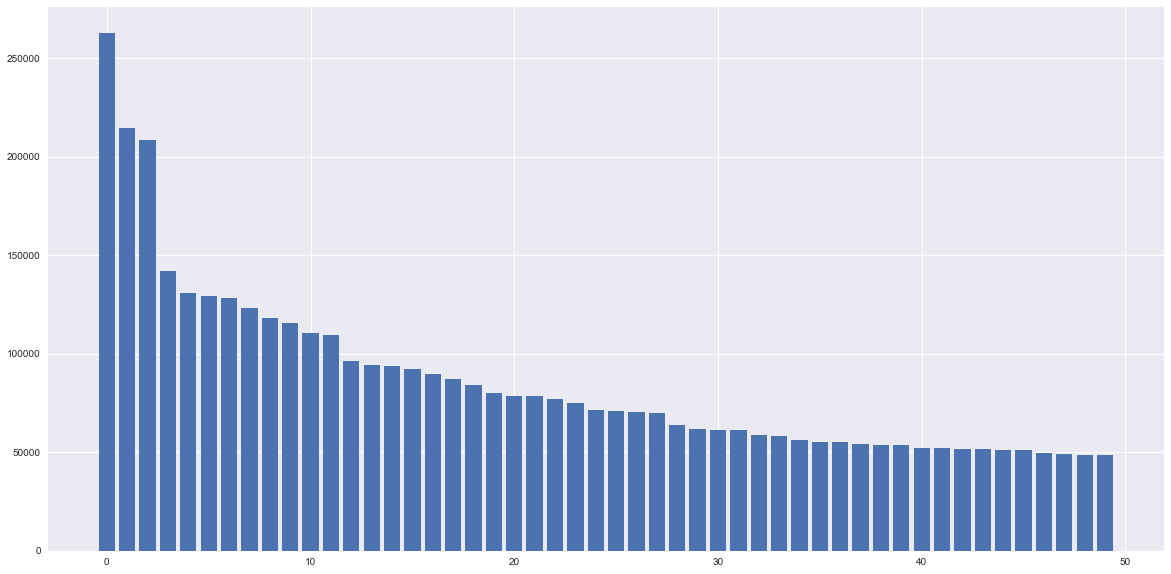

In [30]:
plt.figure(figsize=(20, 10))  # Size of the total canvas

plt.bar(np.arange(len(tuestop.STATION)), tuestop.SUM_PPL)
#plt.xticks = (np.arange(50),(categories))
#plt.xlabel = ('Stations')
plt.ylabel = ('Number of people')
plt.xticks(np.arange(len(stn)),
              [format(x) for x in stn])

In [ ]:
#(range(num_categories),
